In [1]:
# Dateset Loading

In [2]:
>>> from sklearn.datasets import fetch_openml
>>> mnist = fetch_openml('mnist_784', version=1)
>>> mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, includ‐
ing the following:

• A DESCR key describing the dataset

• A data key containing an array with one row per instance and one column per
feature

• A target key containing an array with the labels

In [3]:
>>> X, y = mnist["data"], mnist["target"]
>>> X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it
using Matplotlib’s imshow() function:

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

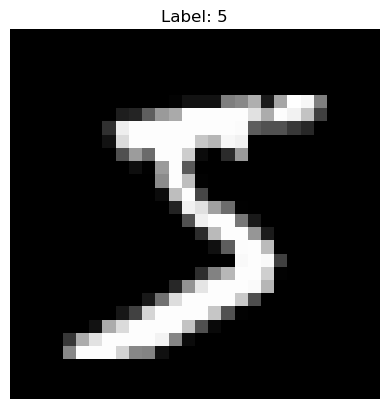

In [6]:
# Get the first image and its label
first_image = mnist.data.iloc[0].values.reshape(28, 28)  # Reshape to 28x28
first_label = mnist.target.iloc[0]

# Plot the first image
plt.imshow(first_image, cmap='gray')
plt.title(f'Label: {first_label}')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [7]:
# This looks like a 5, and indeed that’s what the label tells us:

In [8]:
y[0]

'5'

In [9]:
# Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

y = y.astype(np.uint8)

In [10]:
y[0]

5

Great!!

In [11]:
# Dataset Split :

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:

In [13]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradi‐
ent Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier
has the advantage of being capable of handling very large datasets efficiently. This is
in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s cre‐
ate an SGDClassifier and train it on the whole training set:

In [14]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([mnist.data.iloc[0]])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Performance Measures

In [16]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

Let’s use the cross_val_score() function to evaluate our SGDClassifier model,
using K-fold cross-validation with three folds.

In [17]:
>>> from sklearn.model_selection import cross_val_score
>>> cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
# let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [19]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()

In [21]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

# Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confu‐
sion matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the fifth row and third column of the confu‐
sion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that
they can be compared to the actual targets. You could make predictions on the test
set, but let’s keep it untouched for now (remember that you want to use the test set
only at the very end of your project, once you have a classifier that you are ready to
launch). Instead, you can use the cross_val_predict() function:

In [22]:
# Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
>>> from sklearn.metrics import confusion_matrix
>>> confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [25]:
>>> y_train_perfect_predictions = y_train_5 # pretend we reached perfection
>>> confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [26]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [27]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [28]:
>>> from sklearn.metrics import f1_score
>>> f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [29]:
>>> y_scores = sgd_clf.decision_function([mnist.data.iloc[0]])
>>> y_scores

array([2164.22030239])

In [30]:
>>> threshold = 0
>>> y_some_digit_pred = (y_scores > threshold)

In [31]:
>>> threshold = 8000
>>> y_some_digit_pred = (y_scores > threshold)
>>> y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually repre‐
sents a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000.

How do you decide which threshold to use? First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions:

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.show()

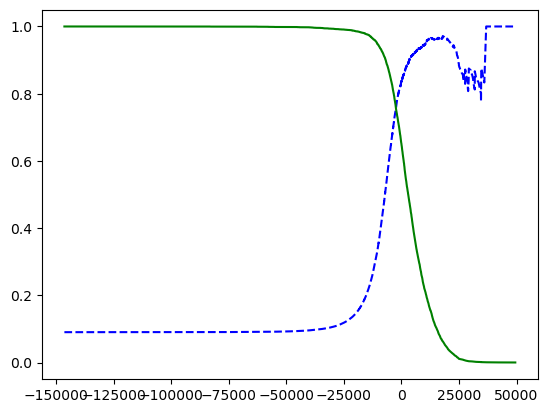

In [35]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# ROC AUC Curve

In [36]:
from sklearn.metrics import roc_curve

In [37]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

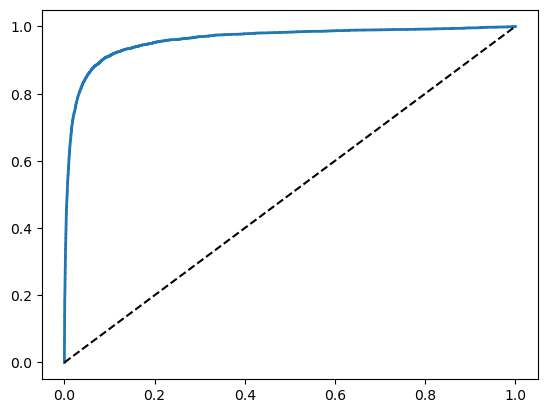

In [39]:
plot_roc_curve(fpr, tpr)
plt.show()

In [40]:
>>> from sklearn.metrics import roc_auc_score
>>> roc_auc_score(y_train_5, y_scores)

0.9604938554008616

One way to compare classifiers is to measure the area under the curve (AUC). A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [41]:
>>> from sklearn.metrics import roc_auc_score
>>> roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now train a RandomForestClassifier and compare its ROC curve and ROC
AUC score to those of the SGDClassifier. First, you need to get scores for each
instance in the training set. But due to the way it works (see Chapter 7), the Random
ForestClassifier class does not have a decision_function() method.


It has a predict_proba() method. Scikit-Learn classifiers generally have one or the
other, or both. The predict_proba() method returns an array containing a row per
instance and a column per class, each containing the probability that the given
instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [42]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [43]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

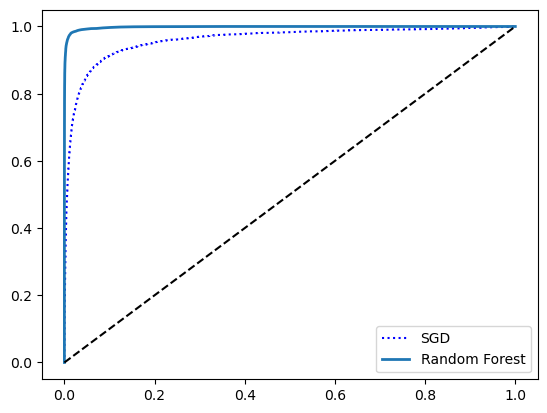

In [44]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

# Multi-Class Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.
Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes
classifiers) are capable of handling multiple classes natively. Others (such as Logistic
Regression or Support Vector Machine classifiers) are strictly binary classifiers. How‐
ever, there are various strategies that you can use to perform multiclass classification
with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to
9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-
detector, and so on). Then when you want to classify an image, you get the decision
score from each classifier for that image and you select the class whose classifier out‐
puts the highest score. This is called the one-versus-the-rest (OvR) strategy (also called
one-versus-all).
Another strategy is to train a binary classifier for every pair of digits: one to distin‐
guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advan‐
tage of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set. For these algorithms OvO is preferred because it is faster to
train many classifiers on small training sets than to train few classifiers on large train‐
ing sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐
class classification task, and it automatically runs OvR or OvO, depending on the
algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5),
using the sklearn.svm.SVC class:

In [46]:
some_digit = mnist.data.iloc[0]
>>> from sklearn.svm import SVC
>>> svm_clf = SVC()
>>> svm_clf.fit(X_train, y_train) # y_train, not y_train_5
>>> svm_clf.predict([some_digit])

array([5], dtype=uint8)

If you call the decision_function() method, you will see that it returns 10 scores
per instance (instead of just 1). That’s one score per class:

In [47]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [48]:
 np.argmax(some_digit_scores)

5

In [49]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
svm_clf.classes_[5]

5

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
scaler = StandardScaler()

In [55]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [57]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=2)

array([0.90543333, 0.89936667])

In [58]:
>>> y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
>>> conf_mx = confusion_matrix(y_train, y_train_pred)
>>> conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

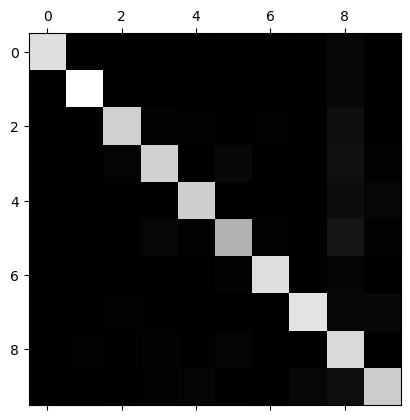

In [59]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diago‐
nal, which means that they were classified correctly. The 5s look slightly darker than
the other digits, which could mean that there are fewer images of 5s in the dataset or
that the classifier does not perform as well on 5s as on other digits. In fact, you can
verify that both are the case.


Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class so that you can compare
error rates instead of absolute numbers of errors (which would make abundant
classes look unfairly bad):

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result:

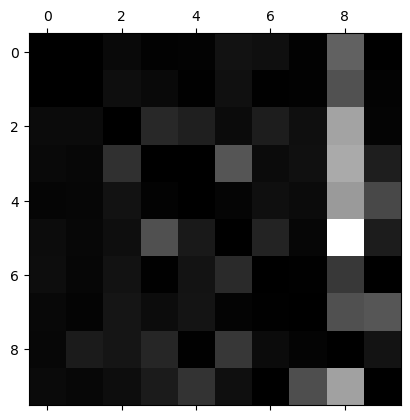

In [61]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

You can clearly see the kinds of errors the classifier makes. Remember that rows rep‐
resent actual classes, while columns represent predicted classes. The column for class
8 is quite bright, which tells you that many images get misclassified as 8s. However,
the row for class 8 is not that bad, telling you that actual 8s in general get properly
classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical.
You can also see that 3s and 5s often get confused (in both directions).


Analyzing the confusion matrix often gives you insights into ways to improve your
classifier. Looking at this plot, it seems that your efforts should be spent on reducing
the false 8s. For example, you could try to gather more training data for digits that
look like 8s (but are not) so that the classifier can learn to distinguish them from real
8s. Or you could engineer new features that would help the classifier—for example,
writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5
has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns, such as closed loops, stand out more.

The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks
on the right show images classified as 5s. Some of the digits that the classifier gets
wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a
human would have trouble classifying them (e.g., the 5 in the first row and second
column truly looks like a badly written 3). However, most misclassified images seem
like obvious errors to us, and it’s hard to understand why the classifier made the mis‐
takes it did.3
 The reason is that we used a simple SGDClassifier, which is a linear
model. All it does is assign a weight per class to each pixel, and when it sees a new
image it just sums up the weighted pixel intensities to get a score for each class. So
since 3s and 5s differ only by a few pixels, this model will easily confuse them.